# Import

In [1]:
# 기본 세팅
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import gaussian_kde
from matplotlib import colors as mpl_colors
import os
import argparse
from datetime import datetime
from glob import glob
from itertools import product, groupby
from mpl_toolkits.mplot3d import Axes3D
import re

# Font & Color

##### TODO
- font download

In [2]:
# font = {'family': 'Tahoma'}
# font = {'family': 'Times New Roman'}

# plt.rc('font', **font)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
grid_color = 'gainsboro'

In [3]:
def layerNum(model:str) -> int:
    if model == "densenet201" :
        return 306
    elif model == "resnet152" :
        return 206
    elif model == "enetb0" :
        return 136
    elif model == "csmobilenet-v2" :
        return 81
    elif model == "squeezenet" :
        return 50
    elif model == "yolov7" :
        return 143
    elif model == "yolov7-tiny" :
        return 99
    elif model == "yolov4" :
        return 162
    elif model == "yolov4-tiny" :
        return 38
    elif model == "resnet10" :
        return 17
    elif model == "yolov2-tiny" :
        return 16
    else :
        print("Unknown model: ", model)
        return 0

def maxCore(device:str) -> int:
    if device == "nano":
        return 4
    if device == "orin":
        return 10
    else:
        print("Unknown device: ", device)
        return 0

### Options

In [13]:
save_formats = ['png', 'pdf', 'svg']
devices = ['nano', 'orin']
types = ["toy_simul", "real_simul", "real_exp"]
models = ['densenet201', 'resnet152', 'enetb0', 'csmobilenet-v2', 'squeezenet', 'yolov7', 'yolov7-tiny', 'yolov4', 'yolov4-tiny', 'resnet10', 'yolov2-tiny']

device = 'nano'
type = "real_exp"
model = "densenet201"
date_label = "0107"

max_cores = maxCore(device)
if type not in types:
    print("Unknown type: ", type)
layer_num = layerNum(model)
if not os.path.exists(f"../../csv/{date_label}"):
    print(f"Invalid date: {date_label}")

In [5]:
for save_format in save_formats:
    directory_path = f'./{save_format}'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"디렉터리 '{directory_path}' 생성 완료!")
    else:
        print(f"디렉터리 '{directory_path}'가 이미 존재합니다.")

디렉터리 './png' 생성 완료!
디렉터리 './pdf' 생성 완료!
디렉터리 './svg' 생성 완료!


### Load csv & Dataframe 생성

##### 1. toy_simul

In [6]:
type = "toy_simul"

In [7]:
if type == "toy_simul":
    models = ["GPU >>> CPU", "GPU >> CPU", "GPU > CPU", "GPU > CPU | GPU < CPU"]
    model = "GPU >>> CPU"
    if model == "GPU >>> CPU":
        # GPU >>> CPU
        cpu_inference_list = [200,400,350,460,570,330,250,290,310,300]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU >> CPU":
        # GPU >>> CPU
        cpu_inference_list = [100,200,150,260,270,130,50,90,110,30]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU > CPU":
        # GPU > CPU
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU > CPU | GPU < CPU":
        # # GPU CPU 반반 (앞이 GPU 효율 좋음)
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,18,14,15,18,5]
    else: print("Unknown mode")

##### 2. real_simul

##### 3. real_exp

In [14]:
cpu_layer_time_path = f"../../csv/{date_label}/layer_time/{model}/cpu_raw_data_01blas.csv"
gpu_layer_time_path = f"../../csv/{date_label}/layer_time/{model}/gpu_raw_data.csv"

In [15]:
gpu_data = pd.read_csv(gpu_layer_time_path)

# 평균값을 저장할 배열
differences = []

# 각 layer에 대한 평균 계산
for i in range(layer_num):
    column_name = f"layer[{i}]"
    mean_value = gpu_data[column_name].mean()
    differences.append(mean_value)

cpu_data = pd.read_csv(cpu_layer_time_path)

# 평균값을 저장할 배열
layer_means = []
# 각 layer에 대한 평균 계산
for i in range(layer_num):
    column_name = f"layer[{i}]"
    mean_value = cpu_data[column_name].mean()
    layer_means.append(mean_value)

x_data = list(range(len(layer_means)))

acceleration_ratio = []
for i in range(layer_num):
    ratio = layer_means[i]/differences[i]
    acceleration_ratio.append(ratio)

# Graph

##### Layer Time

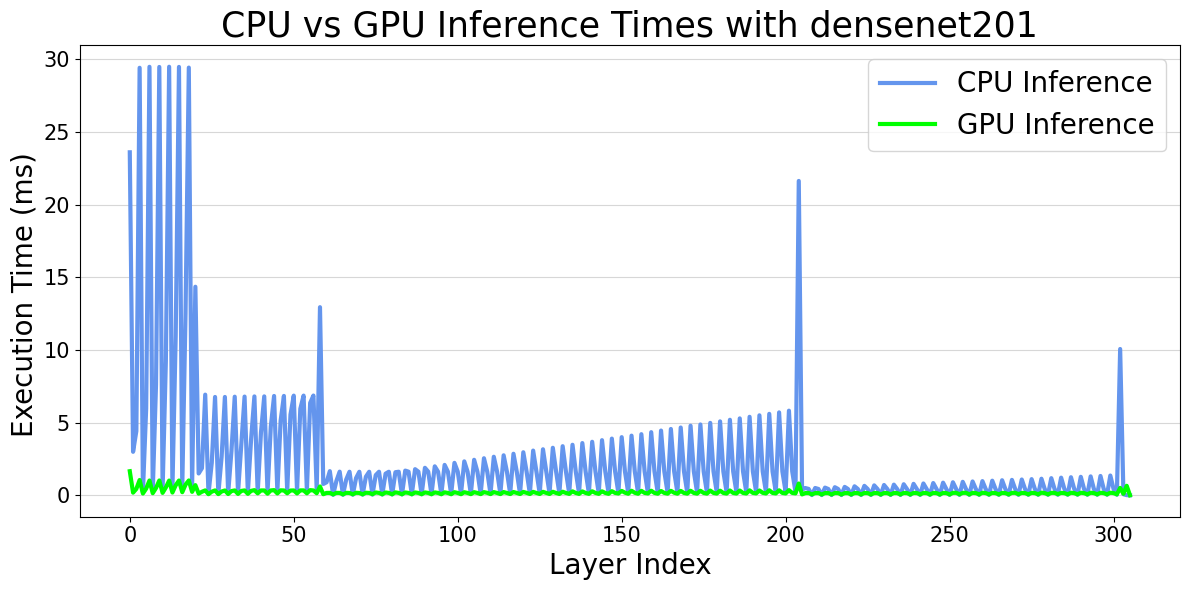

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(layer_means, label='CPU Inference', color = "cornflowerblue", linewidth=3)
plt.plot(differences, label='GPU Inference', color = "lime", linewidth=3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Layer Index', size=20)
plt.ylabel('Execution Time (ms)   ', size=20)
plt.title(f'CPU vs GPU Inference Times with {model}', size=25)
plt.grid(True, axis='y', alpha = 0.5)
plt.legend(fontsize=20, ncol=1, frameon=True)

plt.tight_layout()

for save_format in save_formats:
    plt.savefig(f'./{save_format}/LayerTime-plot-{device}-{type}-{model}-{date_label}.{save_format}')

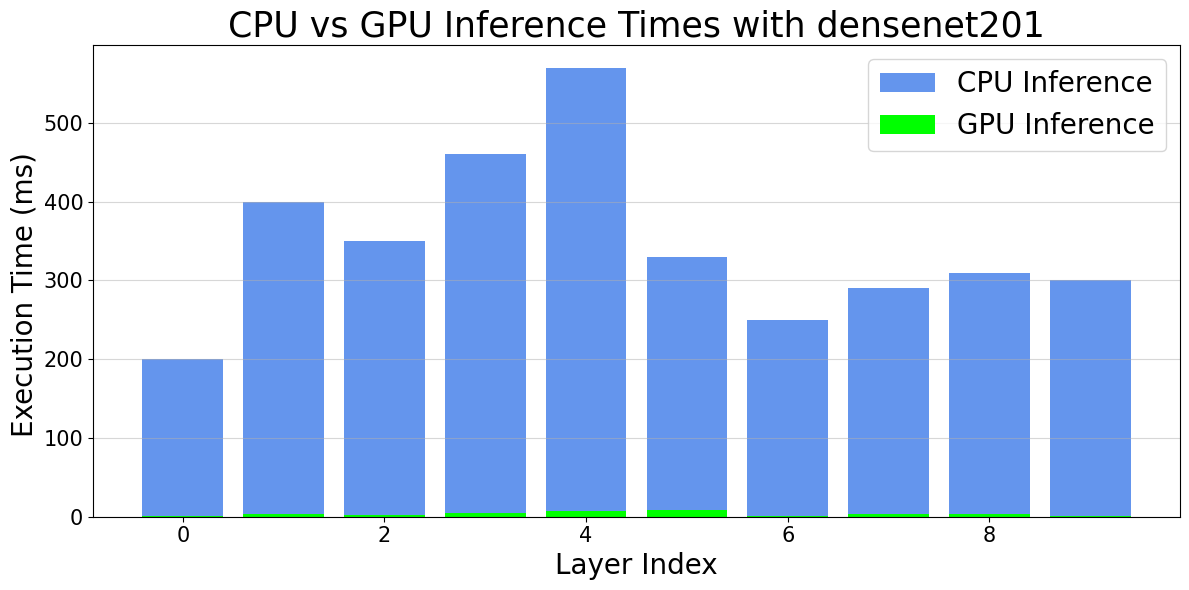

In [17]:
# layer_array = list(range(1, len(layer_means) + 1)) 
layer_indices = np.arange(len(cpu_inference_list))
plt.figure(figsize=(12, 6))
plt.bar(layer_indices, cpu_inference_list, label='CPU Inference', color = "cornflowerblue", linewidth=3)
plt.bar(layer_indices, gpu_inference_list, label='GPU Inference', color = "lime", linewidth=3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Layer Index', size=20)
plt.ylabel('Execution Time (ms)   ', size=20)
plt.title(f'CPU vs GPU Inference Times with {model}', size=25)
plt.grid(True, axis='y', alpha = 0.5)
plt.legend(fontsize=20, ncol=1, frameon=True)

plt.tight_layout()

for save_format in save_formats:
    plt.savefig(f'./{save_format}/LayerTime-bar-{device}-{type}-{model}-{date_label}.{save_format}')